# introduction
This file is used to train an image segmentation model to detect plant diseases in order to be used in an application to detect plant health in real-time and classify what type of disease is it inflicted with if any.

## Dataset used
The dataset used is the PlantVillage Dataset from Kaggle. The dataset can be found [here](https://www.kaggle.com/datasets/alexisbcook/plantvillage).

# 1. Dataset
In this section, we will create:
1. the Dataset class.
2. the DataLoader class.

And we will explore the dataset and visualize each class size in training, validation and test sets.

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
import tqdm
import cv2

## 1.1. Creating a transformation pipeline
The pipeline consists of the following transformations:
1. Resize.
2. RandomCrop.
3. Rotate limit of 40 degrees.
4. HorizontalFlip.
5. VerticalFlip.
6. RGBShift.
7. OneOf: Blur or ColorJitter.
8. Normalize the images.
9. Converting to tensor via ToTensorV2.

In [2]:
# Creating a transformation pipeline using Albumentations
transform = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.1),
    A.RandomRotate90(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.GaussNoise(p=0.1),
    A.ShiftScaleRotate(
        shift_limit=0.05, scale_limit=0.1, rotate_limit=25,
        p=0.3, border_mode=0
    ),
    A.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
        max_pixel_value=255.0,
    ),
    ToTensorV2(),
], additional_targets={'mask': 'mask'})

c:\Users\basel\anaconda3\Lib\site-packages\albumentations\core\validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


## 1.2. Dataset Class & DataLoaders for the Dataset

In [3]:
import os
from pathlib import Path

In [4]:
class PlantVillageSegmentationClassificationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None, num_classes=15):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.num_classes = num_classes
        
        # Get all image paths and extract class labels from directory structure
        self.image_paths = sorted(list(Path(image_dir).rglob("*.jpg")))
        self.mask_paths = []
        self.labels = []
        valid_image_paths = []
        
        print(f"Found {len(self.image_paths)} images, checking for corresponding masks and extracting labels...")
        
        # Create class mapping from directory names
        self.class_to_idx = {}
        class_dirs = sorted([d for d in Path(image_dir).iterdir() if d.is_dir()])
        for idx, class_dir in enumerate(class_dirs):
            self.class_to_idx[class_dir.name] = idx
        
        print(f"Found {len(self.class_to_idx)} classes: {list(self.class_to_idx.keys())}")
        
        for img_path in self.image_paths:
            # Get class from parent directory name
            class_name = img_path.parent.name
            if class_name in self.class_to_idx:
                label = self.class_to_idx[class_name]
                
                # Build corresponding mask path
                rel_path = img_path.relative_to(image_dir)
                mask_path = Path(mask_dir) / rel_path.parent / f"{img_path.stem}_final_masked.jpg"
                
                if mask_path.exists():
                    self.mask_paths.append(mask_path)
                    self.labels.append(label)
                    valid_image_paths.append(img_path)
                else:
                    print(f"Mask missing for: {img_path}")
            else:
                print(f"Unknown class for: {img_path}")
        
        self.image_paths = valid_image_paths
        print(f"Final dataset size: {len(self.image_paths)} images with masks and labels")
        print(f"Class distribution: {np.bincount(self.labels)}")
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image = np.array(Image.open(self.image_paths[idx]).convert("RGB"))
        mask = np.array(Image.open(self.mask_paths[idx]).convert("L"))
        label = self.labels[idx]
        
        if self.transform:
            transformed = self.transform(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]
        
        mask = (mask > 0).float()
        label = torch.tensor(label, dtype=torch.long)
        
        return image, mask, label  # Now returns image, mask, AND class label

- Adding the dataset file locations

In [5]:
dataset_loc = "G:\Work Projects\AI & ML Projects\Plants-Disease-Detection---Identification\data"
color_full_images_dir = "G:\Work Projects\AI & ML Projects\Plants-Disease-Detection---Identification\data\color"
segmented_images_dir = "G:\Work Projects\AI & ML Projects\Plants-Disease-Detection---Identification\data\segmented"

In [6]:
# Add class instances of Train, Validation, Test split datasets
train_dataset = PlantVillageSegmentationClassificationDataset(
    image_dir=os.path.join(color_full_images_dir, 'train'),
    mask_dir=os.path.join(segmented_images_dir, 'train'),
    transform=transform
)

val_dataset = PlantVillageSegmentationClassificationDataset(
    image_dir=os.path.join(color_full_images_dir, 'valid'),
    mask_dir=os.path.join(segmented_images_dir, 'valid'),
    transform=transform
)

test_dataset = PlantVillageSegmentationClassificationDataset(
    image_dir=os.path.join(color_full_images_dir, 'test'),
    mask_dir=os.path.join(segmented_images_dir, 'test'),
    transform=transform
)

# Testing for image size
print(f"Train Dataset Size: {len(train_dataset)}")
print(f"Validation Dataset Size: {len(val_dataset)}")
print(f"Test Dataset Size: {len(test_dataset)}")

Found 42473 images, checking for corresponding masks and extracting labels...
Found 38 classes: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___healthy', 'Corn_(maize)___Northern_Leaf_Blight', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___healthy', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___healthy', 'Potato___Late_blight', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___healthy', 'Strawberry___Leaf_scorch', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___healthy', 'Tomato___Late_blight', 'Toma

In [7]:
# Building DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=0)

In [8]:
# Testing DataLoaders
for images, masks, labels in test_loader:
    for i in range(4):
            print(f"Images Shape: {images.shape}, Masks Shape: {masks.shape}, Labels Shape: {labels.shape}")
            label_idx = labels[i].item()
            class_names = [key for key, value in train_dataset.class_to_idx.items() if value == label_idx]
            print(f"Class Name: {class_names[0]}")

Images Shape: torch.Size([16, 3, 256, 256]), Masks Shape: torch.Size([16, 256, 256]), Labels Shape: torch.Size([16])
Class Name: Apple___Apple_scab
Images Shape: torch.Size([16, 3, 256, 256]), Masks Shape: torch.Size([16, 256, 256]), Labels Shape: torch.Size([16])
Class Name: Apple___Apple_scab
Images Shape: torch.Size([16, 3, 256, 256]), Masks Shape: torch.Size([16, 256, 256]), Labels Shape: torch.Size([16])
Class Name: Apple___Apple_scab
Images Shape: torch.Size([16, 3, 256, 256]), Masks Shape: torch.Size([16, 256, 256]), Labels Shape: torch.Size([16])
Class Name: Apple___Apple_scab
Images Shape: torch.Size([16, 3, 256, 256]), Masks Shape: torch.Size([16, 256, 256]), Labels Shape: torch.Size([16])
Class Name: Apple___Apple_scab
Images Shape: torch.Size([16, 3, 256, 256]), Masks Shape: torch.Size([16, 256, 256]), Labels Shape: torch.Size([16])
Class Name: Apple___Apple_scab
Images Shape: torch.Size([16, 3, 256, 256]), Masks Shape: torch.Size([16, 256, 256]), Labels Shape: torch.Size([

Batch - Images: torch.Size([16, 3, 256, 256]), Masks: torch.Size([16, 256, 256]), Labels: torch.Size([16])


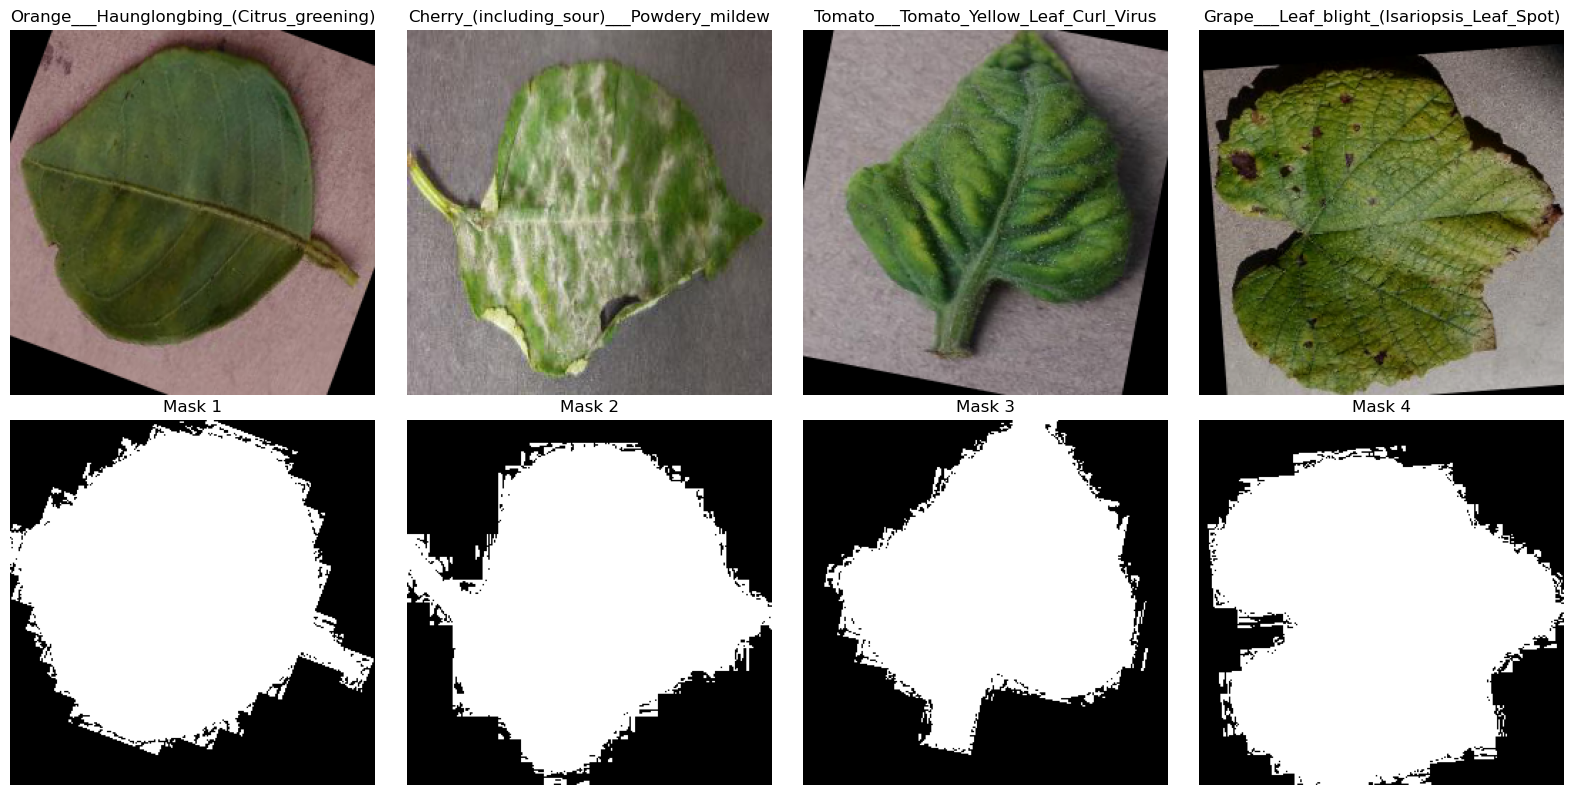

In [28]:
# Function to visualize a batch of images and masks
def visualize_batch(images, masks, labels, num_samples=4):
    fig, axes = plt.subplots(2, num_samples, figsize=(16, 8))
    
    # Denormalization parameters (from your Albumentations transform)
    mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1)
    
    # Denormalize images
    images_denorm = images * std + mean
    images_denorm = torch.clamp(images_denorm, 0, 1)

    # Get Image class names
    label_idx = labels[:num_samples].tolist()
    class_names = [key for key, value in train_dataset.class_to_idx.items()]
    
    for i in range(num_samples):
        # Display image
        axes[0, i].imshow(images_denorm[i].permute(1, 2, 0))
        axes[0, i].set_title(f'{class_names[label_idx[i]]}')
        axes[0, i].axis('off')
        
        # Display mask
        axes[1, i].imshow(masks[i].squeeze(), cmap='gray')
        axes[1, i].set_title(f'Mask {i+1}')
        axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Test it with your data loader
for images, masks, labels in train_loader:
    print(f"Batch - Images: {images.shape}, Masks: {masks.shape}, Labels: {labels.shape}")
    visualize_batch(images, masks, labels)
    break

## 2. Model Building
In this second main section, we will build the Image Segmentation model (U-net) first, then build the classification model (ResNet18) and finally combine them together to form a complete model that segments the image first, then classifies it depending on all the classes present in the dataset.

In [16]:
import torch
import torch.nn as nn

from torchsummary import summary

from torch.optim import Adam, AdamW, SGD

## 2.1. Building the Image Segmentation Model (U-net)

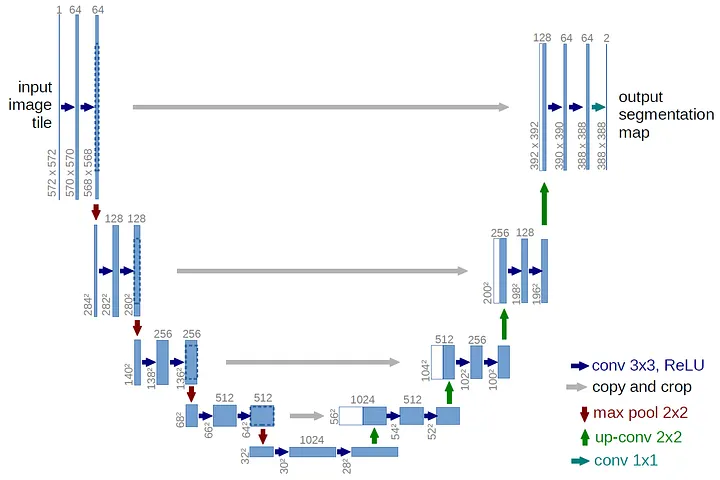

In [11]:
# Double-conv block
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

In [12]:
# Downsampling block
class DownSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = DoubleConv(in_channels, out_channels)
        self.pool = nn.MaxPool2d(2)

    def forward(self, x):
        x_conv = self.conv(x)
        x_pool = self.pool(x_conv)
        return x_conv, x_pool

In [13]:
# Upsampling block
class UpSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels//2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)
    
    def forward(self, x1, x2):
        x1 = self.up(x1)
        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x

In [14]:
# The U-Net model
class Unet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()

        # Encoder blocks (downsampling phase)
        self.down1 = DownSample(in_channels, 64)
        self.down2 = DownSample(64, 128)
        self.down3 = DownSample(128, 256)
        self.down4 = DownSample(256, 512)

        # Middle Phase (Bottleneck)
        self.middle = DoubleConv(512, 1024)

        # Upsample phase
        self.up1 = UpSample(1024, 512)
        self.up2 = UpSample(512, 256)
        self.up3 = UpSample(256, 128)
        self.up4 = UpSample(128, 64)
        
        # Output layer
        self.out = nn.Conv2d(64, num_classes, kernel_size=1)
    
    def forward(self, x):
        down_1, p1 = self.down1(x)
        down_2, p2 = self.down2(p1)
        down_3, p3 = self.down3(p2)
        down_4, p4 = self.down4(p3)
        middle = self.middle(p4)
        up_1 = self.up1(middle, down_4)
        up_2 = self.up2(up_1, down_3)
        up_3 = self.up3(up_2, down_2)
        up_4 = self.up4(up_3, down_1)
        out = self.out(up_4)
        return torch.sigmoid(out)

In [25]:
# Intialize the U-Net Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
segm_model = Unet(3, 1).to(device)

# Print the model summary
print(f"Model Device: {device}")
print("Model Summary:")
print(summary(segm_model, (3, 256, 256)))

Model Device: cuda
Model Summary:
Layer (type:depth-idx)                   Output Shape              Param #
├─DownSample: 1-1                        [-1, 64, 256, 256]        --
|    └─DoubleConv: 2-1                   [-1, 64, 256, 256]        --
|    |    └─Sequential: 3-1              [-1, 64, 256, 256]        38,976
|    └─MaxPool2d: 2-2                    [-1, 64, 128, 128]        --
├─DownSample: 1-2                        [-1, 128, 128, 128]       --
|    └─DoubleConv: 2-3                   [-1, 128, 128, 128]       --
|    |    └─Sequential: 3-2              [-1, 128, 128, 128]       221,952
|    └─MaxPool2d: 2-4                    [-1, 128, 64, 64]         --
├─DownSample: 1-3                        [-1, 256, 64, 64]         --
|    └─DoubleConv: 2-5                   [-1, 256, 64, 64]         --
|    |    └─Sequential: 3-3              [-1, 256, 64, 64]         886,272
|    └─MaxPool2d: 2-6                    [-1, 256, 32, 32]         --
├─DownSample: 1-4                    

## 2.2. Initializing the Image Segmentation Model
This section will contain initializing the modeland getting it ready for training.
We will create:
1. Custom DiceLoss function
2. Custom BCEWithDiceLoss function
3. Learning rate and Criterion for the model.
4. Early Stopping Criteria for the model.

In [20]:
# Implement Dice loss
class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()
        
    def forward(self, input, target):
        smooth = 1.0
        iflat = input.view(-1)
        tflat = target.view(-1)
        intersection = (iflat * tflat).sum()
        dice_loss = 1 - ((2.0 * intersection + smooth) / (iflat.sum() + tflat.sum() + smooth))
        return dice_loss
    
# Implement Custom BCE with Dice loss
class BCEWithDiceLoss(nn.Module):
    def __init__(self):
        super(BCEWithDiceLoss, self).__init__()
        self.criterion = nn.BCEWithLogitsLoss()
        self.dice_loss = DiceLoss()

    def forward(self, input, target):
        bce_loss = self.criterion(input, target)
        dice_loss = self.dice_loss(input, target)
        bce_dice_loss = bce_loss + dice_loss
        return bce_dice_loss

In [23]:
# Custom Early Stopping
class EarlyStopping:
    def __init__(self, patience=7, verbose=True, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = float('inf')
        self.delta = delta

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pth')
        self.val_loss_min = val_loss

## 2.3. Training the Image Segmentation Model

In [ ]:
# Implement Training loop - COMPLETE FIXED VERSION
def train(model_checkpoint_path, epochs, train_loader, val_loader=None, lr=0.0001, save_path='checkpoint_segm.pth', early_stopping_patience=7, early_stopping_delta=0.0001):
    """
    This function implements the training loop for the segmentation model.
    Inputs:
        1. model_checkpoint_path: Path to the model checkpoint file.
        2. epochs: Number of epochs to train the model.
        3. train_loader: Dataloader for the training dataset.
        4. val_loader: Dataloader for the validation dataset (optional).
        5. lr: Learning rate for the optimizer.
        6. save_path: Path to save the trained model.
        7. early_stopping_patience: Patience for early stopping.
        8. early_stopping_delta: Delta for early stopping.
    """
    # Early Stopping
    early_stopping = EarlyStopping(patience=early_stopping_patience, verbose=True, delta=early_stopping_delta)
    
    # Load model
    if model_checkpoint_path and os.path.exists(model_checkpoint_path):
        segm_model.load_state_dict(torch.load(model_checkpoint_path))
        print(f"Loaded model checkpoint from {model_checkpoint_path}")
    else:
        print("No model checkpoint provided. Training from scratch.")
    
    # Criterion + Optimizer
    criterion = BCEWithDiceLoss()
    optimizer = torch.optim.AdamW(segm_model.parameters(), lr=lr, weight_decay=1e-4)
    
    # Learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5, verbose=True)
    
    # Training history
    train_losses = []
    val_losses = []
    
    print("Starting training...")
    
    # Training loop
    for epoch in range(epochs):
        # Training phase
        segm_model.train()
        train_loss = 0.0
        train_batches = 0
        
        for images, masks, labels in train_loader:
            images = images.to(device)
            masks = masks.to(device)
            
            optimizer.zero_grad()
            outputs = segm_model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            train_batches += 1
        
        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # Validation phase
        if val_loader is not None:
            segm_model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for images, masks, labels in val_loader:
                    images = images.to(device)
                    masks = masks.to(device)
                    
                    outputs = segm_model(images)
                    loss = criterion(outputs, masks)
                    val_loss += loss.item()
            
            avg_val_loss = val_loss / len(val_loader)
            val_losses.append(avg_val_loss)
            
            # Update learning rate based on validation loss
            scheduler.step(avg_val_loss)
            
            print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, LR: {optimizer.param_groups[0]['lr']:.6f}")
            
            # Early stopping on validation loss
            early_stopping(avg_val_loss, segm_model)
        else:
            # If no validation loader, use training loss for early stopping
            print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, LR: {optimizer.param_groups[0]['lr']:.6f}")
            early_stopping(avg_train_loss, segm_model)
        
        # Check for early stopping
        if early_stopping.early_stop:
            print("Early stopping triggered.")
            break
        
        # Save checkpoint every 10 epochs
        if (epoch + 1) % 10 == 0:
            checkpoint_path = f"{save_path}_epoch_{epoch+1}.pth"
            torch.save(segm_model.state_dict(), checkpoint_path)
            print(f"Model checkpoint saved: {checkpoint_path}")
    
    # Save final model
    final_path = f"{save_path}_final.pth"
    torch.save(segm_model.state_dict(), final_path)
    print(f"Training complete. Final model saved: {final_path}")
    
    # Plot training history
    if val_loader is not None:
        plt.figure(figsize=(10, 6))
        plt.plot(train_losses, label='Training Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.legend()
        plt.grid(True)
        plt.show()
    
    return train_losses, val_losses if val_loader is not None else train_losses

In [ ]:
train_losses, val_losses = train(
    model_checkpoint_path=None,
    epochs=100,
    train_loader=train_loader,
    val_loader=val_loader, 
    lr=0.0001,
    save_path='plant_segmentation_model',
    early_stopping_patience=10,
    early_stopping_delta=0.001
)